<br/>

$$ \huge{\underline{\textbf{ Q-Learning }}} $$

<br/>

<center>Implementation of <b>Q-Learning</b></center>
<center>from Sutton and Barto 2018, <b>chapter 6.5</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<br/>

<img src="assets/0605_Q_Learning.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 6.5 </center>

<br/>

In [1]:
def q_learning(env, ep, gamma, alpha, eps):
    """Q-Learning (off-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[st,a] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)
    
    Q = defaultdict(float)  # default zero for all, terminal MUST be zero
    
    for _ in range(ep):
        S = env.reset()
        while True:
            A = policy(S, Q, eps)
            S_, R, done = env.step(A)
            max_Q = np.max([Q[S_,a] for a in env.act_space])
            Q[S,A] = Q[S,A] + alpha * (R + gamma * max_Q - Q[S,A])
            S = S_
            if done: break
                            
    return Q

Helper functions:

In [2]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

---

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_0605a.png"/></td>
        <td style="border-color: white;"><img src="assets/fig_0605b.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;" colspan="2"><center>Example 6.6<center/></td>
    </tr>
</table>

# Solve Cliff Walking

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from helpers_0605 import plot_cliffwalk

Auxiliary code here: [helpers_0605.py](helpers_0605.py)

Cliff Walking environment, as described in the book example 6.6, along with my x,y convention.
<img src="assets/0605_cliffwalking.png"/>

In [22]:
class CliffWalkingEnv:
    def __init__(self):
        self.act_space = [0, 1, 2, 3]  # LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self.reset()
        
    def reset(self):
        self._x, self._y = 0, 0        # agent initial position
        return (0, 0)
        
    def step(self, action):
        """actions: LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3"""
        self._x, self._y = self.transition(self._x, self._y, action)
        
        if self._x in range(1,11) and self._y == 0:  # CLIFF spanning x=[1..10]
            self._x, self._y = 0, 0                  #  teleport to start
            return (self._x, self._y), -100, False   #  return -100 reward
        if self._x == 11 and self._y == 0:           # GOAL at (11,0)
            return (self._x, self._y), -1, True      #  -1, terminate
        return (self._x, self._y), -1, False         # NORMAL states
        
    def transition(self, x, y, action):
        """Perform transition from [x,y] given action. Does not teleport."""
        
        if action == 0:    x -= 1     # left
        elif action == 1:  y -= 1     # down
        elif action == 2:  x += 1     # right
        elif action == 3:  y += 1     # up
        else: raise ValueError('Action must be in [0,1,2,3]')
            
        x = np.clip(x, 0, 11)   # x range is [0..11] incl.
        y = np.clip(y, 0, 3)    # y range is [0..3] incl.
        return x, y
    
    def get_path(self, Q):
        """Returns a path agent would take, if following greedy Q-based policy"""
        x, y = 0, 0       # agent starting position
        path = [(x, y)]   # save starting position
        for _ in range(100):  # limit steps in case policy is loopy
            A_star = np.argmax([Q[(x,y),a] for a in [0, 1, 2, 3]])   # pick best action
            x, y = self.transition(x, y, A_star)         # take one step
            path.append((x,y))                           # save to path
            if x in range(1,11) and y == 0:              # CLIFF
                path.append((0, 0))                      # teleport
            if x == 11 and y == 0:  break                # GOAL at (11,0)
        return path

Create environment

In [7]:
env = CliffWalkingEnv()

Solve. 100 episodes usually enough.

In [20]:
Q = q_learning(env, ep=100, gamma=1., alpha=.5, eps=.1)

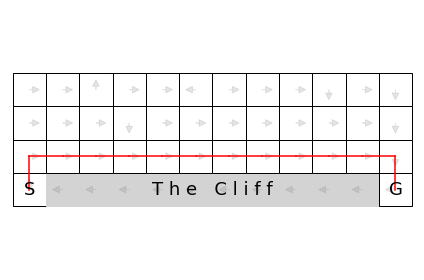

In [21]:
path = env.get_path(Q)
plot_cliffwalk(Q, path_red=path)

# Recreate example 6.6

We need to bring back Sarsa algorithm from section 5.5. We also need to modify both algorithms to track cumulative reward (*R_sum*) at each episode.

In [96]:
def sarsa_ext(env, ep, gamma, alpha, eps):
    def policy(st, Q, eps):
        if np.random.rand() > eps: return argmax_rand([Q[st,a] for a in env.act_space])
        else:                      return np.random.choice(env.act_space)
    
    Q = defaultdict(float)  # default 0
    
    rewards = []            # Change: track episode rewards
    for _ in range(ep):
        rewards.append(0)       #  <--
        S = env.reset()
        A = policy(S, Q, eps)
        while True:
            S_, R, done = env.step(A)
            A_ = policy(S_, Q, eps)
            Q[S,A] = Q[S,A] + alpha * (R + gamma * Q[S_,A_] - Q[S,A])
            S, A = S_, A_
            rewards[-1] += R   #  <--
            if done: break
    return Q, rewards

In [97]:
def q_learning_ext(env, ep, gamma, alpha, eps):
    def policy(st, Q, eps):
        if np.random.rand() > eps: return argmax_rand([Q[st,a] for a in env.act_space])
        else:                      return np.random.choice(env.act_space)
    
    Q = defaultdict(float)  # default 0
    
    rewards = []            # Change: track episode rewards
    for _ in range(ep):
        rewards.append(0)       #  <--
        S = env.reset()
        while True:
            A = policy(S, Q, eps)
            S_, R, done = env.step(A)
            max_Q = np.max([Q[S_,a] for a in env.act_space])
            Q[S,A] = Q[S,A] + alpha * (R + gamma * max_Q - Q[S,A])
            S = S_
            rewards[-1] += R   #  <--
            if done: break
    return Q, rewards

### Example 6.6 - safe/optimal paths

Solve both environments. May take more than one attempt to get exactly right.

In [62]:
Q_ql, _ = q_learning_ext(env, ep=100, gamma=1., alpha=.5, eps=.1)
Q_sr, _ = sarsa_ext(env, ep=10000, gamma=1., alpha=.5, eps=.1)

Plot both solutions.

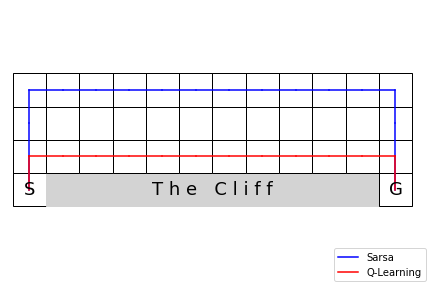

In [125]:
path_qlearn = env.get_path(Q_ql)
path_sarsa = env.get_path(Q_sr)
plot_cliffwalk(path_blue=path_sarsa, path_red=path_qlearn,
               labels=['Sarsa', 'Q-Learning'], saveimg=None)  # 'assets/fig_0605a.png'

### Example 6.6 - online performance comparison

I was not able to reproduce wavy look of second plot in example 6.6. Bood doesn't seem to desribe how exactly second plot was produced. Following convention from the rest of the book I averaged data over multiple runs, which seems to produce similar results, but with different noise distribution. If anyone know how exactly that plot was reproduced drop me a msg.
* We will run sarsa and q_learning 100 times each
* Each run will be consisted of 500 complete episodes $t\in[1..T]$
* Each episode will provide single data point equal to sum of reward in this episode

In [162]:
def perform_experiments(n_runs):
    R_ql_runs = []  # sum of rewards, dim [n_runs, nb_episodes]
    R_sr_runs = []

    for i in range(n_runs):  # 100 runs
        # 500 episodes, each episode providing one data point
        _, hist = q_learning_ext(env, ep=500, gamma=1., alpha=.5, eps=.1)
        R_ql_runs.append(hist)

        _, hist = sarsa_ext(env, ep=500, gamma=1., alpha=.5, eps=.1)
        R_sr_runs.append(hist)

    # Average over all runs
    R_ql_avg = np.average(R_ql_runs, axis=0)
    R_sr_avg = np.average(R_sr_runs, axis=0)
    
    return R_ql_avg, R_sr_avg, n_runs

Run experiments

In [157]:
R_ql_avg, R_sr_avg = perform_experiments(100)  # ~2min

Plot results

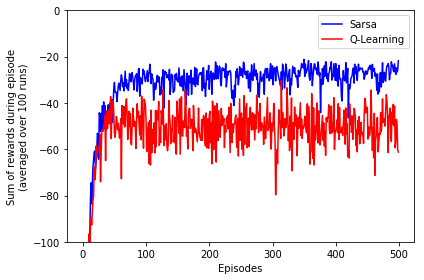

In [163]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(R_sr_avg, color='blue', label='Sarsa')
ax.plot(R_ql_avg, color='red', label='Q-Learning')
ax.set_ylim([-100,0])
ax.legend()
ax.set_xlabel('Episodes')
ax.set_ylabel('Sum of rewards during episode\n(averaged over '+str(n_runs)+' runs)')
plt.tight_layout()
# plt.savefig('assets/fig_0605b.png')
plt.show()